# 네이버 영화리뷰 감성분석 도전하기

## 0. 모듈 import

In [1]:
import pandas as pd
import numpy as np
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
import os
import gensim
from gensim.models import KeyedVectors
from collections import Counter
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 1. 데이터 준비와 확인

다음 주소에서 다운 받은 자료를 사용한다.  
https://github.com/e9t/nsmc

In [2]:
train_data = pd.read_table('~/aiffel/Exploration/E07_AnalysisNaverMovieReviews/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/Exploration/E07_AnalysisNaverMovieReviews/data/ratings_test.txt')

train_data.head(10)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
5,5403919,막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.,0
6,7797314,원작의 긴장감을 제대로 살려내지못했다.,0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0
8,7156791,액션이 없는데도 재미 있는 몇안되는 영화,1
9,5912145,왜케 평점이 낮은건데? 꽤 볼만한데.. 헐리우드식 화려함에만 너무 길들여져 있나?,1


2번 평을 보면 칭찬인것 같은데, label은 0이다.  
위의 데이터를 만드는데 네이버 평점을 반영한 것으로 생각되는데,  
2번째는 반어법으로 문장을 작성하였거나 단순히 실수 일수도 있다.

다만 학습과정에서 문장만으로 감성을 평가해야하는데, 저런 경우는 노이즈라고도 볼 수 있겠다.  
일단 전체적인 데이터는 잘 맞는 것 같고, 소수의 노이즈는 무시하자.

## 2. 데이터로더 구성

위의 텍스트 데이터를 받아서 가공된 학습 데이터와 테스트 데이터를 반환하는  
데이터 로더를 만들어 보자.

In [3]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    print(f'총 단어수 : {len(counter)}, 사용할 단어수 : {num_words}')
    counter = counter.most_common(num_words-4)
    #word_to_index["<PAD>"] = 0
    #word_to_index["<BOS>"] = 1
    #word_to_index["<UNK>"] = 2  # unknown
    #word_to_index["<UNUSED>"] = 3
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [4]:
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

총 단어수 : 53961, 사용할 단어수 : 10000


In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3. 모델구성을 위한 데이터 분석 및 가공

### 데이터셋 내 문장 길이 분포

In [6]:
print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


### 적절한 최대 문장 길이 지정

In [7]:
index_to_word = {index:word for word, index in word_to_index.items()}
#print(index_to_word.keys())
print(word_to_index['추천'])

281


In [8]:
print(get_decoded_sentence(x_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


In [9]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

pad를 앞쪽과 뒤쪽 모두 넣은 경우 모두를 생성해서 비교해보자.

In [10]:
x_train_post = keras.preprocessing.sequence.pad_sequences(x_train, value=word_to_index["<PAD>"], padding='post', maxlen=maxlen)
x_test_post = keras.preprocessing.sequence.pad_sequences(x_test, value=word_to_index["<PAD>"], padding='post', maxlen=maxlen)

x_train_pre = keras.preprocessing.sequence.pad_sequences(x_train, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)
x_test_pre = keras.preprocessing.sequence.pad_sequences(x_test, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)

print(x_train_post.shape)

(146182, 41)


## 4. 모델구성 및 validation set 구성

여러 개의 모델을 구성해보자.

우선 40000만개의 데이터를 validation set으로 구성하자.

In [11]:
# validation set
x_val_post = x_train_post[:40000]
x_val_pre = x_train_pre[:40000]
y_val = y_train[:40000]   

# train set
partial_x_train_post = x_train_post[40000:]  
partial_x_train_pre = x_train_pre[40000:]
partial_y_train = y_train[40000:]

print(partial_x_train_post.shape)
print(partial_y_train.shape)

(106182, 41)
(106182,)


### RNN을 사용한 모델

In [12]:
# 하이퍼 파라미터
vocab_size = 10000
word_vector_dim = 100
lstm_output = 128
dense_ouput = 512


rnn_model = keras.Sequential()
rnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
rnn_model.add(keras.layers.LSTM(lstm_output))
rnn_model.add(keras.layers.Dense(dense_ouput, activation='relu'))
rnn_model.add(keras.layers.Dense(1, activation='sigmoid'))

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 512)               66048     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 1,183,809
Trainable params: 1,183,809
Non-trainable params: 0
_________________________________________________________________


### 1-D Convolution을 사용한 모델

In [13]:
# 하이퍼 파라미터
vocab_size = 10000
word_vector_dim = 100
conv_filters = 64
conv_kernel_size = 7
dense_ouput = 128

cnn_model = keras.Sequential()
cnn_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
cnn_model.add(keras.layers.Conv1D(conv_filters, conv_kernel_size, activation='relu'))
cnn_model.add(keras.layers.MaxPooling1D(5))
cnn_model.add(keras.layers.Conv1D(conv_filters, conv_kernel_size, activation='relu'))
cnn_model.add(keras.layers.GlobalMaxPooling1D())
cnn_model.add(keras.layers.Dense(dense_ouput, activation='relu'))
cnn_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          44864     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 64)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          28736     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### GlobalMaxPooling1D 사용하는 모델

In [14]:
# 하이퍼 파라미터
vocab_size = 10000
word_vector_dim = 100
dense_ouput = 128

glo_model = keras.Sequential()
glo_model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
glo_model.add(keras.layers.GlobalMaxPooling1D())
glo_model.add(keras.layers.Dense(dense_ouput, activation='relu'))
glo_model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

glo_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 100)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               12928     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 1,013,057
Trainable params: 1,013,057
Non-trainable params: 0
_________________________________________________________________


## 5. 모델 훈련 개시

위에서 만든 모델들을 학습 시키자.  
간편하게 함수로 만들어 여러 모델과 데이터에 대하여 학습을 시킨다.

In [15]:
def train_model(model, x, y, epochs, batch_size, val_data):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(x, y, epochs=epochs, batch_size=batch_size, validation_data=val_data, verbose=1)
    
    return history

rnn모델을 post와 pre 데이터로 학습시켜보자.

In [16]:
rnn_history = train_model(rnn_model, partial_x_train_post, partial_y_train, 10, 512, (x_val_post, y_val))

Epoch 1/10
208/208 [==============================] - 10s 35ms/step - loss: 0.5693 - accuracy: 0.6483 - val_loss: 0.3583 - val_accuracy: 0.8407
Epoch 2/10
208/208 [==============================] - 6s 31ms/step - loss: 0.3363 - accuracy: 0.8564 - val_loss: 0.3551 - val_accuracy: 0.8449
Epoch 3/10
208/208 [==============================] - 6s 31ms/step - loss: 0.3002 - accuracy: 0.8738 - val_loss: 0.3536 - val_accuracy: 0.8457
Epoch 4/10
208/208 [==============================] - 6s 31ms/step - loss: 0.2765 - accuracy: 0.8836 - val_loss: 0.3445 - val_accuracy: 0.8516
Epoch 5/10
208/208 [==============================] - 6s 31ms/step - loss: 0.2496 - accuracy: 0.8972 - val_loss: 0.3436 - val_accuracy: 0.8521
Epoch 6/10
208/208 [==============================] - 6s 31ms/step - loss: 0.2243 - accuracy: 0.9093 - val_loss: 0.4091 - val_accuracy: 0.8543
Epoch 7/10
208/208 [==============================] - 7s 31ms/step - loss: 0.2003 - accuracy: 0.9187 - val_loss: 0.4440 - val_accuracy: 0.850

In [17]:
results = rnn_model.evaluate(x_test_post,  y_test, verbose=2)
print(f'결과 : {results}')

1537/1537 - 5s - loss: 0.5171 - accuracy: 0.8364
결과 : [0.5170636177062988, 0.8363610506057739]


In [18]:
rnn_history_pre = train_model(rnn_model, partial_x_train_pre, partial_y_train, 10, 512, (x_val_pre, y_val))

Epoch 1/10
208/208 [==============================] - 9s 34ms/step - loss: 0.1705 - accuracy: 0.9349 - val_loss: 0.4631 - val_accuracy: 0.8487
Epoch 2/10
208/208 [==============================] - 6s 31ms/step - loss: 0.1205 - accuracy: 0.9559 - val_loss: 0.5393 - val_accuracy: 0.8433
Epoch 3/10
208/208 [==============================] - 7s 31ms/step - loss: 0.1095 - accuracy: 0.9597 - val_loss: 0.5915 - val_accuracy: 0.8417
Epoch 4/10
208/208 [==============================] - 7s 31ms/step - loss: 0.1010 - accuracy: 0.9622 - val_loss: 0.6830 - val_accuracy: 0.8464
Epoch 5/10
208/208 [==============================] - 6s 31ms/step - loss: 0.0895 - accuracy: 0.9660 - val_loss: 0.6979 - val_accuracy: 0.8467
Epoch 6/10
208/208 [==============================] - 7s 31ms/step - loss: 0.0816 - accuracy: 0.9702 - val_loss: 0.8045 - val_accuracy: 0.8413
Epoch 7/10
208/208 [==============================] - 7s 32ms/step - loss: 0.0744 - accuracy: 0.9718 - val_loss: 0.8456 - val_accuracy: 0.8404

In [19]:
results = rnn_model.evaluate(x_test_pre,  y_test, verbose=2)
print(f'결과 : {results}')

1537/1537 - 5s - loss: 0.8781 - accuracy: 0.8360
결과 : [0.8780755400657654, 0.8360355496406555]


마찬가지로 cnn가 globalmaxpooling모델을 사용한 경우도 학습시켜본다.

In [20]:
cnn_history = train_model(cnn_model, partial_x_train_post, partial_y_train, 10, 512, (x_val_post, y_val))

Epoch 1/10
208/208 [==============================] - 10s 36ms/step - loss: 0.5373 - accuracy: 0.6973 - val_loss: 0.3403 - val_accuracy: 0.8516
Epoch 2/10
208/208 [==============================] - 4s 21ms/step - loss: 0.2942 - accuracy: 0.8781 - val_loss: 0.3344 - val_accuracy: 0.8545
Epoch 3/10
208/208 [==============================] - 4s 21ms/step - loss: 0.2076 - accuracy: 0.9218 - val_loss: 0.3571 - val_accuracy: 0.8510
Epoch 4/10
208/208 [==============================] - 4s 21ms/step - loss: 0.1181 - accuracy: 0.9606 - val_loss: 0.4496 - val_accuracy: 0.8437
Epoch 5/10
208/208 [==============================] - 4s 21ms/step - loss: 0.0644 - accuracy: 0.9791 - val_loss: 0.5683 - val_accuracy: 0.8401
Epoch 6/10
208/208 [==============================] - 5s 22ms/step - loss: 0.0398 - accuracy: 0.9874 - val_loss: 0.6848 - val_accuracy: 0.8420
Epoch 7/10
208/208 [==============================] - 4s 21ms/step - loss: 0.0261 - accuracy: 0.9918 - val_loss: 0.8012 - val_accuracy: 0.834

In [21]:
results = cnn_model.evaluate(x_test_post,  y_test, verbose=2)
print(f'결과 : {results}')

1537/1537 - 4s - loss: 0.9110 - accuracy: 0.8346
결과 : [0.9110322594642639, 0.8345504999160767]


In [22]:
cnn_history = train_model(cnn_model, partial_x_train_pre, partial_y_train, 10, 512, (x_val_pre, y_val))

Epoch 1/10
208/208 [==============================] - 5s 23ms/step - loss: 0.2048 - accuracy: 0.9166 - val_loss: 0.4581 - val_accuracy: 0.8455
Epoch 2/10
208/208 [==============================] - 4s 21ms/step - loss: 0.0735 - accuracy: 0.9731 - val_loss: 0.6081 - val_accuracy: 0.8396
Epoch 3/10
208/208 [==============================] - 4s 21ms/step - loss: 0.0403 - accuracy: 0.9860 - val_loss: 0.7955 - val_accuracy: 0.8372
Epoch 4/10
208/208 [==============================] - 4s 21ms/step - loss: 0.0279 - accuracy: 0.9898 - val_loss: 0.9071 - val_accuracy: 0.8414
Epoch 5/10
208/208 [==============================] - 4s 21ms/step - loss: 0.0264 - accuracy: 0.9902 - val_loss: 0.8492 - val_accuracy: 0.8354
Epoch 6/10
208/208 [==============================] - 4s 21ms/step - loss: 0.0210 - accuracy: 0.9923 - val_loss: 0.9811 - val_accuracy: 0.8364
Epoch 7/10
208/208 [==============================] - 4s 21ms/step - loss: 0.0221 - accuracy: 0.9919 - val_loss: 0.9782 - val_accuracy: 0.8320

In [23]:
results = cnn_model.evaluate(x_test_pre,  y_test, verbose=2)
print(f'결과 : {results}')

1537/1537 - 3s - loss: 1.1444 - accuracy: 0.8311
결과 : [1.1444281339645386, 0.8310515284538269]


In [24]:
glo_history = train_model(glo_model, partial_x_train_post, partial_y_train, 10, 512, (x_val_post, y_val))

Epoch 1/10
208/208 [==============================] - 3s 13ms/step - loss: 0.5650 - accuracy: 0.7200 - val_loss: 0.3472 - val_accuracy: 0.8478
Epoch 2/10
208/208 [==============================] - 3s 12ms/step - loss: 0.3058 - accuracy: 0.8709 - val_loss: 0.3387 - val_accuracy: 0.8533
Epoch 3/10
208/208 [==============================] - 3s 13ms/step - loss: 0.2523 - accuracy: 0.8997 - val_loss: 0.3500 - val_accuracy: 0.8523
Epoch 4/10
208/208 [==============================] - 3s 12ms/step - loss: 0.2045 - accuracy: 0.9239 - val_loss: 0.3744 - val_accuracy: 0.8486
Epoch 5/10
208/208 [==============================] - 3s 12ms/step - loss: 0.1632 - accuracy: 0.9414 - val_loss: 0.4127 - val_accuracy: 0.8457
Epoch 6/10
208/208 [==============================] - 3s 12ms/step - loss: 0.1227 - accuracy: 0.9598 - val_loss: 0.4629 - val_accuracy: 0.8416
Epoch 7/10
208/208 [==============================] - 3s 13ms/step - loss: 0.0875 - accuracy: 0.9734 - val_loss: 0.5303 - val_accuracy: 0.8365

In [25]:
results = glo_model.evaluate(x_test_post,  y_test, verbose=2)
print(f'결과 : {results}')

1537/1537 - 2s - loss: 0.7286 - accuracy: 0.8290
결과 : [0.7285672426223755, 0.8290375471115112]


In [26]:
glo_history = train_model(glo_model, partial_x_train_pre, partial_y_train, 10, 512, (x_val_pre, y_val))

Epoch 1/10
208/208 [==============================] - 3s 13ms/step - loss: 0.0264 - accuracy: 0.9921 - val_loss: 0.8271 - val_accuracy: 0.8292
Epoch 2/10
208/208 [==============================] - 3s 13ms/step - loss: 0.0194 - accuracy: 0.9942 - val_loss: 0.9137 - val_accuracy: 0.8279
Epoch 3/10
208/208 [==============================] - 3s 12ms/step - loss: 0.0135 - accuracy: 0.9957 - val_loss: 0.9677 - val_accuracy: 0.8281
Epoch 4/10
208/208 [==============================] - 3s 13ms/step - loss: 0.0112 - accuracy: 0.9961 - val_loss: 1.0252 - val_accuracy: 0.8253
Epoch 5/10
208/208 [==============================] - 3s 12ms/step - loss: 0.0091 - accuracy: 0.9964 - val_loss: 1.0780 - val_accuracy: 0.8243
Epoch 6/10
208/208 [==============================] - 3s 12ms/step - loss: 0.0083 - accuracy: 0.9966 - val_loss: 1.1288 - val_accuracy: 0.8261
Epoch 7/10
208/208 [==============================] - 3s 12ms/step - loss: 0.0077 - accuracy: 0.9968 - val_loss: 1.1819 - val_accuracy: 0.8244

In [27]:
results = glo_model.evaluate(x_test_pre,  y_test, verbose=2)
print(f'결과 : {results}')

1537/1537 - 2s - loss: 1.3684 - accuracy: 0.8172
결과 : [1.3683699369430542, 0.8171979784965515]


## 6.  Loss, Accuracy 그래프 시각화

history를 이용하여 학습 과정을 그래프로 시각화시켜보자.

In [28]:
history_dict = rnn_history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [29]:
def draw_history(history):
    fig = plt.figure()
    loss_ax = fig.add_subplot(2, 1, 1)
    acc_ax = fig.add_subplot(2, 1, 2)
    
    loss_ax.plot(history.history['loss'], 'y', label='train loss')
    loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
    acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
    
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuray')
    
    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

    plt.show()

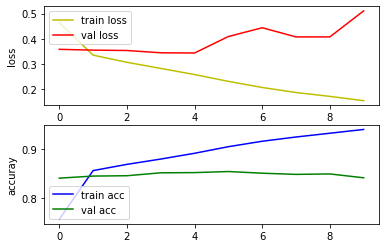

In [30]:
draw_history(rnn_history)

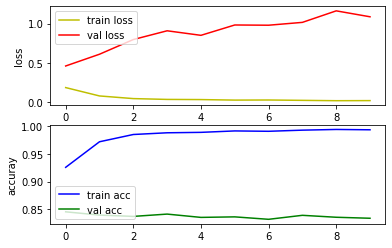

In [31]:
draw_history(cnn_history)

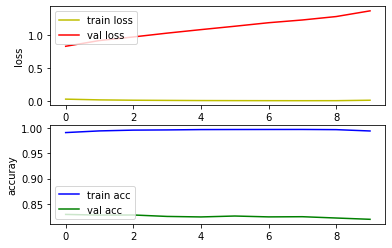

In [32]:
draw_history(glo_history)

학습 결과를 확인한 결과 예상 외로 pad를 pre에 넣은 것 보다 post를 넣은 경우가 더 좋은 결과가 나왔다.

그리고 전반적으로 학습할수록 validation이 떨어지는 걸로보아 overfit된걸로 보인다.  
dropout이나, batchnormalize같은 레이어를 추가하여야 할 거 같다.

## 7. 학습된 Embedding 레이어 분석

위의 학습으로 만들어진 임베딩 레이어를 분석해보자.

In [34]:
embedding_layer = rnn_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 100)


In [36]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/Exploration/E07_AnalysisNaverMovieReviews/data/word2vec_rnn.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = rnn_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

위에서 저장한 word2vec를 gensim을 이용하여 활용해보자.

In [38]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 0.01781549, -0.04791987,  0.04822287,  0.02396975, -0.04763526,
       -0.00391535, -0.00032974,  0.00153115, -0.04410589,  0.01621325,
       -0.00970161, -0.00065181, -0.01877561,  0.01648282,  0.02526707,
       -0.01483635, -0.05240749, -0.0186971 , -0.01086484,  0.01572185,
        0.03678608, -0.00578166, -0.04981833, -0.00783142,  0.03978392,
        0.0422303 ,  0.05099586,  0.00290733, -0.01983805, -0.01608467,
       -0.04543546, -0.00532634,  0.02262577,  0.0186555 ,  0.02215891,
        0.05301909,  0.03314031,  0.01262058, -0.00134843, -0.04497351,
       -0.03389598, -0.08406056,  0.00579309, -0.01358179,  0.01444559,
       -0.03401092,  0.01461152,  0.05646025,  0.01904467, -0.02343385,
        0.00710843, -0.06060328, -0.0259028 , -0.05978473, -0.0455312 ,
       -0.02372305,  0.02554787,  0.03175697,  0.04955297,  0.00951195,
       -0.01514804,  0.01983827,  0.08765844,  0.03172155, -0.01172354,
       -0.05517138,  0.00979511,  0.04239251,  0.0659629 ,  0.06

단어 임베딩이 잘 학습되었는지 확인하기 위해서 유사한 단어를 출력시켜보자.

In [39]:
word_vectors.similar_by_word("추천")

[('괜춘', 0.8696855306625366),
 ('~!!!', 0.8576535582542419),
 ('강렬', 0.8508882522583008),
 ('부조리', 0.8500752449035645),
 ('끝장', 0.8481454849243164),
 ('막연', 0.8442492485046387),
 ('이제서야', 0.8419989347457886),
 ('준다면', 0.8411141633987427),
 ('풍성', 0.8403722047805786),
 ('소울', 0.8402131795883179)]

가장 비슷한 3개는 추천의 의미와 비슷한것 같은데,  
'부조리'나 '이제서야'같은 연관성이 없어 보이는 단어들도 보인다.

아마 한정된 영화리뷰에서 학습을 하다보니 실제의미보다는  
단순히 감정을 나타내는 부분에서 겹치는 단어가 우연히 많아서  
그런게 아닐까 예상해본다.

## 8. 한국어 Word2Vec 임베딩 활용하여 성능개선

위와 같이 학습된 임베딩 레이어를 분석한 결과 실제 유사한 단어들이  
이상한 경우도 있는것 같다.

그래서 미리 학습된 임베딩을 활용하여 성능을 개선시켜보자.

출저 : https://github.com/Kyubyong/wordvectors

In [40]:
word2vec_path = os.getenv('HOME')+'/aiffel/Exploration/E07_AnalysisNaverMovieReviews/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path).wv
word2vec.vectors.shape

(30185, 200)

총 단어 개수는 30185개에 200차원의 벡터를 가진다.  
영화리뷰에서 사용된 토큰화된 단어가 5만개 쯤이었으니, 모든 단어를 포함하지는 못할듯 하다.

일단 불러온 임베딩의 단어 유사도를 확인해보자.

In [43]:
result = word2vec.most_similar("추천")
print(result)

[('위촉', 0.6401861906051636), ('천거', 0.6389721632003784), ('추대', 0.5849215984344482), ('선출', 0.5803494453430176), ('초청', 0.5759262442588806), ('발탁', 0.5613522529602051), ('선정', 0.5511638522148132), ('임명', 0.5414161682128906), ('초빙', 0.5363222360610962), ('기용', 0.5326868295669556)]


너무 사전적인 단어들만 학습된게 아닐까 싶기도하다.

In [44]:
vocab_size = 10000 
word_vector_dim = 200

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)
nonpretrained_words = []

pretrained_count = 0
# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]
        pretrained_count += 1
    else:
        nonpretrained_words.append(index_to_word[i])

print(f'미리 학습된 임베딩 단어 개수 : {pretrained_count}')
print(nonpretrained_words[:20])

미리 학습된 임베딩 단어 개수 : 5807
[',', '봤', '했', 'ㅋㅋ', '~', '1', 'ㅋㅋㅋ', '10', '재미없', '2', '3', '입니다', "'", '이게', '된', '봐도', '인데', '^^', '만든', '합니다']


가장 많이 사용된 단어 10000개를 기준으로 5800개 가량의 단어가  
미리 학습된 임베딩에 존재하였고, 나머지 'ㅋㅋ', '재미없'와 같이  
의성어나 완성되지 못한 단어들은 따로 학습을 시켜주어야 할 듯 하다.

이전의 오버피팅을 고려해서 dropout레이어들을 추가하였다.

In [70]:
# 하이퍼 파라미터
vocab_size = 10000
word_vector_dim = 200
lstm_output = 128
dense_ouput_1 = 512
dense_ouput_2 = 256


model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.SpatialDropout1D(0.4))
model.add(keras.layers.LSTM(lstm_output, return_sequences=True, dropout=0.2))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(dense_ouput_1, activation='relu'))
model.add(keras.layers.Dense(dense_ouput_2, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, None, 200)         2000000   
_________________________________________________________________
spatial_dropout1d_18 (Spatia (None, None, 200)         0         
_________________________________________________________________
lstm_28 (LSTM)               (None, None, 128)         168448    
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_30 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_31 (Dense)             (None, 1)               

In [71]:
history = train_model(model, partial_x_train_pre, partial_y_train, 10, 512, (x_val_pre, y_val))

Epoch 1/10
208/208 [==============================] - 12s 49ms/step - loss: 0.5303 - accuracy: 0.6968 - val_loss: 0.3606 - val_accuracy: 0.8416
Epoch 2/10
208/208 [==============================] - 10s 46ms/step - loss: 0.3192 - accuracy: 0.8650 - val_loss: 0.3190 - val_accuracy: 0.8610
Epoch 3/10
208/208 [==============================] - 10s 48ms/step - loss: 0.2719 - accuracy: 0.8865 - val_loss: 0.3280 - val_accuracy: 0.8597
Epoch 4/10
208/208 [==============================] - 10s 48ms/step - loss: 0.2430 - accuracy: 0.9014 - val_loss: 0.3304 - val_accuracy: 0.8627
Epoch 5/10
208/208 [==============================] - 10s 47ms/step - loss: 0.2168 - accuracy: 0.9147 - val_loss: 0.3444 - val_accuracy: 0.8599
Epoch 6/10
208/208 [==============================] - 10s 48ms/step - loss: 0.1959 - accuracy: 0.9225 - val_loss: 0.3692 - val_accuracy: 0.8546
Epoch 7/10
208/208 [==============================] - 10s 48ms/step - loss: 0.1776 - accuracy: 0.9300 - val_loss: 0.3755 - val_accuracy:

In [72]:
results = model.evaluate(x_test_pre,  y_test, verbose=2)
print(f'결과 : {results}')

1537/1537 - 5s - loss: 0.4546 - accuracy: 0.8493
결과 : [0.45462512969970703, 0.8493195176124573]


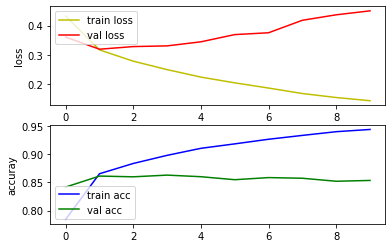

In [73]:
draw_history(history)

다음으로 cnn에도 dropout을 추가하여 결과를 보자.

In [74]:
# 하이퍼 파라미터
vocab_size = 10000
word_vector_dim = 200
conv_filters = 64
conv_kernel_size = 7
dense_ouput = 128

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.SpatialDropout1D(0.4))
model.add(keras.layers.Conv1D(conv_filters, conv_kernel_size, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Conv1D(conv_filters, conv_kernel_size, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(dense_ouput, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 41, 200)           2000000   
_________________________________________________________________
spatial_dropout1d_19 (Spatia (None, 41, 200)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 64)            89664     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 7, 64)             0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 64)             28736     
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 64)              

In [75]:
history = train_model(model, partial_x_train_pre, partial_y_train, 10, 512, (x_val_pre, y_val))

Epoch 1/10
208/208 [==============================] - 11s 44ms/step - loss: 0.6715 - accuracy: 0.5737 - val_loss: 0.4936 - val_accuracy: 0.7671
Epoch 2/10
208/208 [==============================] - 8s 39ms/step - loss: 0.5108 - accuracy: 0.7514 - val_loss: 0.4261 - val_accuracy: 0.8087
Epoch 3/10
208/208 [==============================] - 8s 38ms/step - loss: 0.4446 - accuracy: 0.7936 - val_loss: 0.3815 - val_accuracy: 0.8328
Epoch 4/10
208/208 [==============================] - 8s 37ms/step - loss: 0.4020 - accuracy: 0.8186 - val_loss: 0.3574 - val_accuracy: 0.8433
Epoch 5/10
208/208 [==============================] - 8s 38ms/step - loss: 0.3734 - accuracy: 0.8327 - val_loss: 0.3514 - val_accuracy: 0.8491
Epoch 6/10
208/208 [==============================] - 8s 38ms/step - loss: 0.3554 - accuracy: 0.8433 - val_loss: 0.3406 - val_accuracy: 0.8526
Epoch 7/10
208/208 [==============================] - 8s 38ms/step - loss: 0.3392 - accuracy: 0.8525 - val_loss: 0.3314 - val_accuracy: 0.857

In [76]:
results = model.evaluate(x_test_pre,  y_test, verbose=2)
print(f'결과 : {results}')

1537/1537 - 4s - loss: 0.3323 - accuracy: 0.8566
결과 : [0.33228668570518494, 0.85658198595047]


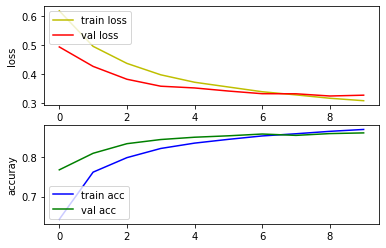

In [77]:
draw_history(history)

최종 정확도는 0.856이 나왔다.

## 9. 회고

이번 프로젝트를 진행하면서 언어 임베딩에 많은 것을 공부하게되었다.  
이전에 이미지를 임베딩 벡터로 만들때와는 달리 자연어는 임베딩 레이어를  
가장 먼저 설정하였다.

이미지는 조금의 변화로도 새롭게 변화는데 반해 자연어는 각 단어를 표현하는  
정해진 벡터로 표현 할 수 있기 때문에 이런식으로 임베딩 벡터를 학습 시키는 것 같다.

거기에 더해 감정이라는 매우 추상적인 개념을 판단할 수 있는 모델을 만드는 것도 신기한 경험이었다.

미리 학습된 임베딩 데이터를 파인튜닝 하는과정에서 생각보다 큰 효과를 보지 못하였다.  
일단 미리 학습된 한글 임베딩의 단어가 3만개 정도로 적은 수여서 모든 단어를 포함하지 못하였고,  
확인해보니 리뷰를 토큰화한 단어에는 완성되지 못한 단어나 의성어 등의 전처리가 완벽하지 못한점도 있었다.  

그 외에도 불용어라는 처음보는 개념등은 더 공부해야 할 것 같다.